In [1]:
from zipfile import ZipFile

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import spacy
from nltk.corpus import wordnet as wn
%matplotlib inline

In [2]:
nlp = spacy.load('en_core_web_md')

In [3]:
with ZipFile('snli_1.0.zip') as archive:
    names = archive.namelist()
    print('\n'.join([name for name in names if '.DS' not in name and '__MACOSX' not in name]))
    df_dev = pd.read_json(archive.open("snli_1.0/snli_1.0_dev.jsonl"), lines=True)
    df_test = pd.read_json(archive.open("snli_1.0/snli_1.0_test.jsonl"), lines=True)
    df_train = pd.read_json(archive.open("snli_1.0/snli_1.0_train.jsonl"), lines=True)

snli_1.0/
snli_1.0/Icon
snli_1.0/README.txt
snli_1.0/snli_1.0_dev.jsonl
snli_1.0/snli_1.0_dev.txt
snli_1.0/snli_1.0_test.jsonl
snli_1.0/snli_1.0_test.txt
snli_1.0/snli_1.0_train.jsonl
snli_1.0/snli_1.0_train.txt


In [4]:
def remove_unset(df):
    new_df = df[df['gold_label'] != '-'].copy().reset_index()
    return new_df
df_dev = remove_unset(df_dev)
df_test = remove_unset(df_test)
df_train = remove_unset(df_train)

In [5]:
df_dev.shape, df_test.shape, df_train.shape

((9842, 11), (9824, 11), (549367, 11))

In [6]:
eda = df_dev.copy()
eda = eda[['gold_label', 'sentence1', 'sentence2']]

In [7]:
eda['sent1_len'] = eda['sentence1'].str.len()
eda['sent2_len'] = eda['sentence2'].str.len()
eda.head(3)

,gold_label,sentence1,sentence2,sent1_len,sent2_len
0,neutral,Two women are embracing while holding to go pa...,The sisters are hugging goodbye while holding ...,53,85
1,entailment,Two women are embracing while holding to go pa...,Two woman are holding packages.,53,31
2,contradiction,Two women are embracing while holding to go pa...,The men are fighting outside a deli.,53,36


In [8]:
eda.describe()

,sent1_len,sent2_len
count,9842.000000,9842.000000
mean,72.250457,37.897887
std,32.890431,16.385647
min,13.000000,6.000000
25%,48.000000,27.000000
50%,64.000000,35.000000
75%,93.000000,45.000000
max,300.000000,232.000000


In [9]:
eda.sort_values('sent2_len')

,gold_label,sentence1,sentence2,sent1_len,sent2_len
1064,entailment,A sleeping toddler has toppled out of his crib.,A baby,47,6
7946,contradiction,The brown dog next to the swimming pool has a ...,A dog died,64,10
8819,entailment,"A man sitting at a desk, repairing antique typ...",a man sits,55,10
3903,entailment,A group of men are seated around a table and e...,Men eating,52,10
4615,contradiction,A large group of people walking down a city st...,a man sits,51,10
8094,contradiction,An Asian man attempting to repair a green bicy...,Just a bike,94,11
8091,entailment,An Asian man attempting to repair a green bicy...,Some humans,94,11
9781,contradiction,A West Virginia university women's basketball ...,a dog barks,122,11
26,contradiction,A young boy in a field of flowers carrying a ball,dog in pool,49,11
9477,contradiction,Two black and white dogs looking at a black an...,No animals.,110,11


In [10]:
eda['gold_label'].value_counts()

entailment       3329
contradiction    3278
neutral          3235
Name: gold_label, dtype: int64

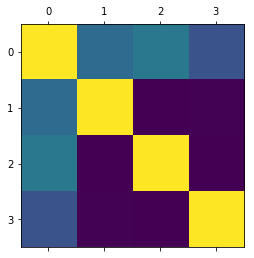

In [11]:
subset = eda[['gold_label', 'sent1_len', 'sent2_len']].copy()
subset['diff'] = subset['sent1_len'] - subset['sent2_len']
df_dummies = pd.get_dummies(subset['gold_label'])

subset = pd.concat([subset, df_dummies], axis=1)
del subset['gold_label']
plt.matshow(subset[['diff', 'contradiction', 'entailment', 'neutral']].corr(method='spearman'))
# seems that there's no obvious correlation between difference of lengths between between sentences
# (yet biggest one is for neutral class)

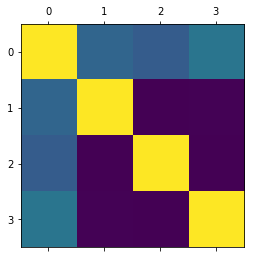

In [12]:
subset['sum'] = subset['sent1_len'] + subset['sent2_len']
plt.matshow(subset[['sum', 'contradiction', 'entailment', 'neutral']].corr(method='spearman'))
# same for sum of lengths, although this time neutral and positive seems more correlated, yet not significantly

In [13]:
nlp_cache = {}
def run_nlp(string):
    doc = None
    if string in nlp_cache:
        doc = nlp_cache[string]
    else:
        doc = nlp(string)
        nlp_cache[string] = doc
    return doc

# Baseline

In [14]:
# 1st idea - let's count overlapping lemmas, skipping stop words and IN/DT
def is_meaningful(tok):
    if tok.is_stop:
        return False
    if tok.is_punct:
        return False
    if tok.tag_ in ['IN', 'DT']:
        return False
    return True
def get_basic_form(tok):
    if tok.lemma_.startswith('-') and tok.lemma_.endswith('-'):
        return str(tok)
    else:
        return tok.lemma_
def overlapping_words(row):
    given_doc = run_nlp(row['sentence1'].lower())
    hypothesis_doc = run_nlp(row['sentence2'].lower())
    given_words = set([get_basic_form(tok) for tok in given_doc if is_meaningful(tok)])
    hypot_words = set([get_basic_form(tok) for tok in hypothesis_doc if is_meaningful(tok)])
    return set(given_words) & set(hypot_words)

def to_len_X(df):
    return df.apply(lambda r: len(overlapping_words(r)), axis=1)

def reshape_x(X):
    return X.values.reshape((len(X),1))

In [15]:
X_len_train = reshape_x(to_len_X(df_train))
y_len_train = df_train['gold_label']
X_len_dev = reshape_x(to_len_X(df_dev))
y_len_dev = df_dev['gold_label']

In [16]:
predictor = LogisticRegression()
predictor.fit(X_len_train, y_len_train)
y_predicted = predictor.predict(X_len_dev)
print(metrics.classification_report(y_len_dev, y_predicted))

               precision    recall  f1-score   support

contradiction       0.42      0.76      0.54      3278
   entailment       0.46      0.53      0.50      3329
      neutral       0.00      0.00      0.00      3235

  avg / total       0.30      0.44      0.35      9842



/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


First I tried memoizing spacy's work and jupyter just ate all the available RAM and swapped into 0 bytes left on disk. After heroically fighting with this issue (which took 15 minutes to recover from) I removed memoization and it took several hours to run on whole dataset, so I'm not tuning anything in this Baseline and considering this good enough

In [ ]:
# 2nd idea - average w2v on sentences and cosine similiarity

# Further work